In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
#Import music dataframe
musicr = pd.read_pickle('DFs/musicr.pkl')

In [3]:
#import motion dataframe of only participant 1
motion1 = pd.read_pickle('DFs/Participant_Motion/PID_motion_1.pkl')

In [4]:
#import demographic information dataframe, includes all participants, but we will only use partiicpant 1 info for now
demos = pd.read_pickle('DFs/demos_clean.pkl')

Reminder of what each look like

### Matching Times Between DataFrames
We need to match the musics and motion DataFrames together. We will create a 'time' column that repersents hundreths of seconds from the start of the motion capture. The music starts at 3 minutes or 18000 hundreths of a second

In [5]:
motion1['time(hs)'] = list(range(0,36001))
musicr['time(hs)'] = list(range(18000,35601))

In [6]:
motion1

,X,Y,Z,PID,time(hs)
0,159.596,1845.594,1732.156,1,0
1,159.583,1845.451,1732.144,1,1
2,159.584,1845.308,1732.126,1,2
3,159.587,1845.180,1732.105,1,3
4,159.597,1845.072,1732.103,1,4
...,...,...,...,...,...
35996,160.090,1837.312,1715.629,1,35996
35997,160.122,1837.488,1715.619,1,35997
35998,160.128,1837.653,1715.597,1,35998
35999,160.147,1837.829,1715.599,1,35999


In [7]:
#merge the motion and music data together on time column
par1 = musicr.merge(motion1, on='time(hs)', how='left')
par1.head()

,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,A,A_sharp,B,time(hs),X,Y,Z,PID
0,0.391866,0.271475,0.543743,0.414470,0.615711,0.905505,0.693868,1.0,0.873349,0.428765,0.196232,0.178688,18000,164.657,1864.265,1721.860,1
1,0.391006,0.270759,0.542460,0.419167,0.611465,0.895052,0.696120,1.0,0.865096,0.424725,0.202718,0.177431,18001,164.624,1864.225,1721.870,1
2,0.384290,0.269616,0.530845,0.424728,0.596871,0.879191,0.701280,1.0,0.854621,0.410783,0.205452,0.178596,18002,164.599,1864.181,1721.861,1
3,0.368410,0.266402,0.511752,0.433351,0.582881,0.878751,0.706602,1.0,0.850467,0.397394,0.211017,0.174648,18003,164.577,1864.140,1721.864,1
4,0.356740,0.260931,0.492235,0.435323,0.570510,0.877007,0.707534,1.0,0.849687,0.381047,0.214705,0.177209,18004,164.547,1864.106,1721.850,1


In [8]:
#We are goingt o only look at PID 1 currently so we can drop the column which acts as a constant currently
par1.drop(columns='PID', inplace=True)
par1.head()

,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,A,A_sharp,B,time(hs),X,Y,Z
0,0.391866,0.271475,0.543743,0.414470,0.615711,0.905505,0.693868,1.0,0.873349,0.428765,0.196232,0.178688,18000,164.657,1864.265,1721.860
1,0.391006,0.270759,0.542460,0.419167,0.611465,0.895052,0.696120,1.0,0.865096,0.424725,0.202718,0.177431,18001,164.624,1864.225,1721.870
2,0.384290,0.269616,0.530845,0.424728,0.596871,0.879191,0.701280,1.0,0.854621,0.410783,0.205452,0.178596,18002,164.599,1864.181,1721.861
3,0.368410,0.266402,0.511752,0.433351,0.582881,0.878751,0.706602,1.0,0.850467,0.397394,0.211017,0.174648,18003,164.577,1864.140,1721.864
4,0.356740,0.260931,0.492235,0.435323,0.570510,0.877007,0.707534,1.0,0.849687,0.381047,0.214705,0.177209,18004,164.547,1864.106,1721.850


In [9]:
#par1 = par1.merge(demos_clean, on='PID', how='left')
#par1

# Feature Creation
We are giong to create some additonal features from the note amplitudes including rolling averages, mins, maxs and rates of change

In [10]:
def note_features(note_column_df, note):
    feature_df = pd.DataFrame()
    feature_df[note + '_5sec_avg'] = note_column_df.rolling(500).mean()
    feature_df[note + '_2.5sec_avg'] = note_column_df.rolling(250).mean()
    feature_df[note + '_1sec_avg'] = note_column_df.rolling(100).mean()
    feature_df[note + '_10sec_max'] = note_column_df.rolling(500).max()
    feature_df[note + '_5sec_max'] = note_column_df.rolling(250).max()
    feature_df[note + '_1sec_max'] = note_column_df.rolling(100).max()
    feature_df[note + '_10sec_min'] = note_column_df.rolling(500).min()
    feature_df[note + '_5sec_min'] = note_column_df.rolling(250).min()
    feature_df[note + '_1sec_min'] = note_column_df.rolling(100).min()
    feature_df[note + '_10sec_diff'] = note_column_df.rolling(500).max() - note_column_df.rolling(250).min()
    feature_df[note + '_5sec_diff'] = note_column_df.rolling(250).max() - note_column_df.rolling(50).min()
    feature_df[note + '_1sec_diff'] = note_column_df.rolling(100).max() - note_column_df.rolling(100).min()
    return feature_df

In [11]:
musicr

,C,C_sharp,D,D_sharp,E,F,F_sharp,G,G_sharp,A,A_sharp,B,time(hs)
0,0.391866,0.271475,0.543743,0.414470,0.615711,0.905505,0.693868,1.000000,0.873349,0.428765,0.196232,0.178688,18000
1,0.391006,0.270759,0.542460,0.419167,0.611465,0.895052,0.696120,1.000000,0.865096,0.424725,0.202718,0.177431,18001
2,0.384290,0.269616,0.530845,0.424728,0.596871,0.879191,0.701280,1.000000,0.854621,0.410783,0.205452,0.178596,18002
3,0.368410,0.266402,0.511752,0.433351,0.582881,0.878751,0.706602,1.000000,0.850467,0.397394,0.211017,0.174648,18003
4,0.356740,0.260931,0.492235,0.435323,0.570510,0.877007,0.707534,1.000000,0.849687,0.381047,0.214705,0.177209,18004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17596,0.551258,0.239016,0.590822,0.848327,0.556109,0.694828,1.000000,0.846755,0.592610,0.795401,0.520809,0.609293,35596
17597,0.486828,0.255034,0.616595,0.832311,0.567620,0.685870,1.000000,0.849619,0.508727,0.755731,0.539001,0.600682,35597
17598,0.418250,0.280371,0.653649,0.814706,0.601733,0.692381,1.000000,0.866687,0.420425,0.728755,0.549097,0.572606,35598
17599,0.418250,0.280371,0.653649,0.814706,0.601733,0.692381,1.000000,0.866687,0.420425,0.728755,0.549097,0.572606,35599


In [12]:
nf = musicr.drop(columns=['time(hs)'])
for note in nf.columns:
    nf = nf.merge(note_features(musicr[note], note), left_index=True, right_index=True)

<Figure size 432x288 with 0 Axes>

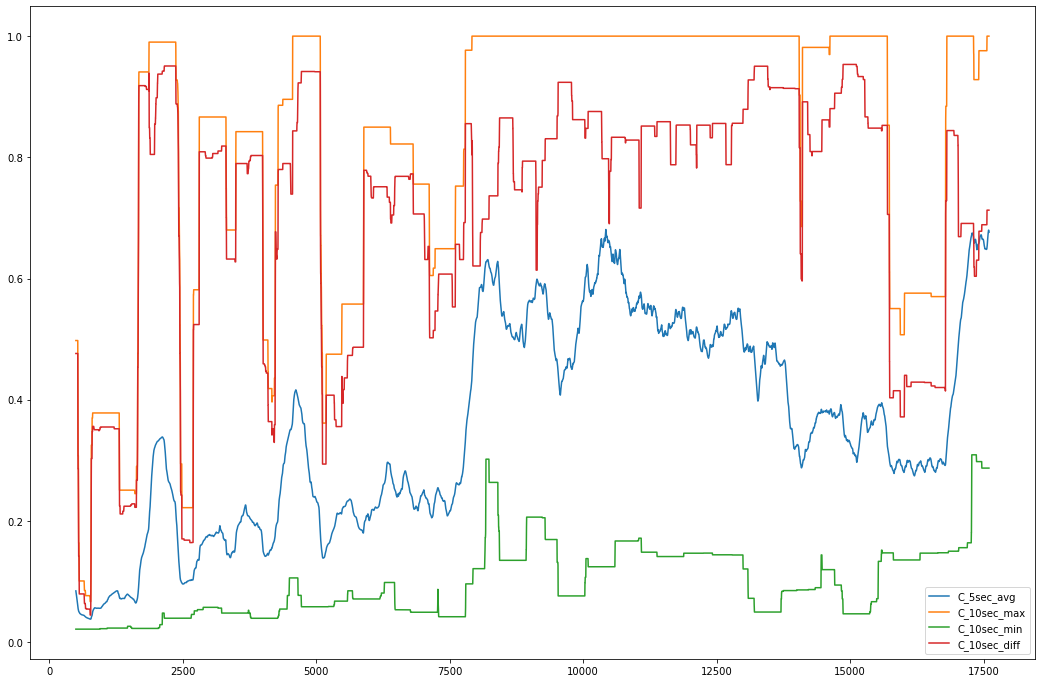

<Figure size 432x288 with 0 Axes>

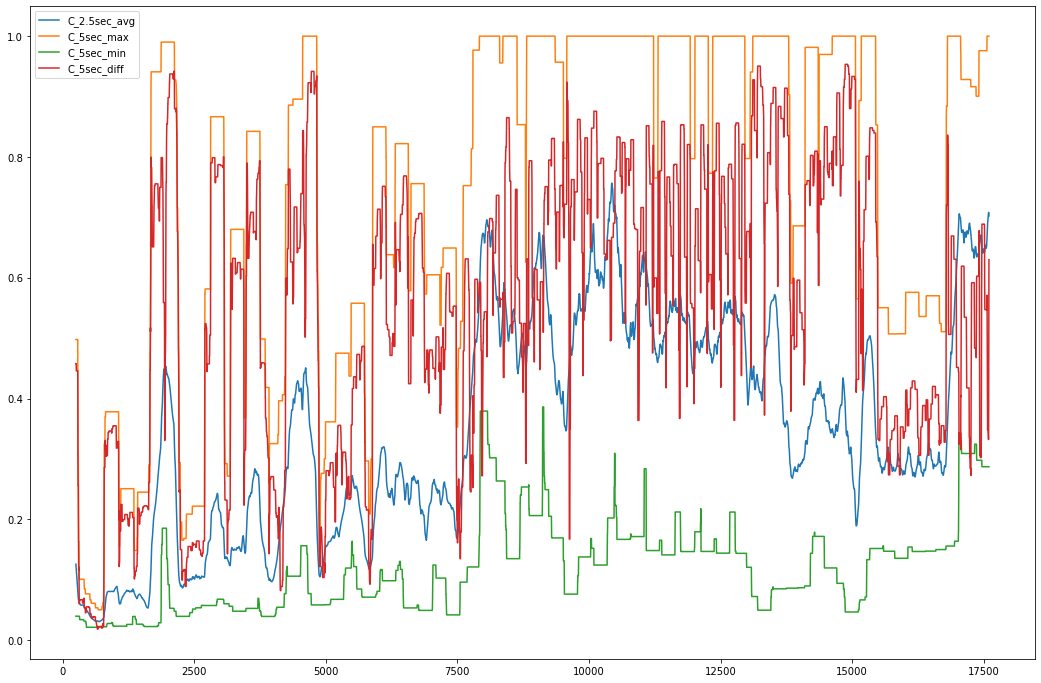

<Figure size 432x288 with 0 Axes>

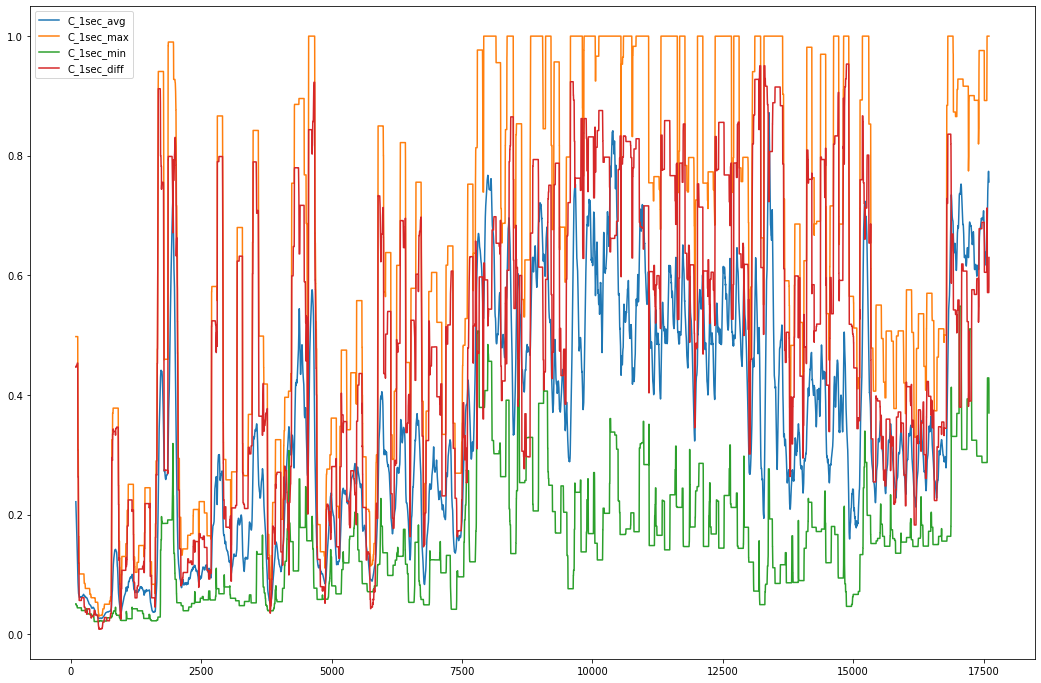

In [13]:
plt.figure()
nf.iloc[:,[12, 15, 18, 21]].plot(figsize=(18, 12))
plt.figure()
nf.iloc[:,[13, 16, 19, 22]].plot(figsize=(18, 12))
plt.figure()
nf.iloc[:,[14, 17 ,20, 23]].plot(figsize=(18, 12))
plt.show()

In [14]:
def motion_levels(XYZ, PID):
    feature_df = pd.DataFrame()
    feature_df[PID + '_X_disp1_avg'] = XYZ['X'].diff().rolling(100).mean()
    feature_df[PID + '_X_disp1_min'] = XYZ['X'].diff().rolling(100).min()
    feature_df[PID + '_X_disp1_max'] = XYZ['X'].diff().rolling(100).max()
    feature_df[PID + '_Y_disp1_avg'] = XYZ['Y'].diff().rolling(100).mean()
    feature_df[PID + '_Y_disp1_min'] = XYZ['Y'].diff().rolling(100).min()
    feature_df[PID + '_Y_disp1_max'] = XYZ['Y'].diff().rolling(100).max()
    feature_df[PID + '_Z_disp1_avg'] = XYZ['Z'].diff().rolling(100).mean()
    feature_df[PID + '_Z_disp1_min'] = XYZ['Z'].diff().rolling(100).min()
    feature_df[PID + '_Z_disp1_max'] = XYZ['Z'].diff().rolling(100).max()
    feature_df[PID + '_X_disp2_avg'] = XYZ['X'].diff().rolling(200).mean()
    feature_df[PID + '_Y_disp2_avg'] = XYZ['Y'].diff().rolling(200).mean()
    feature_df[PID + '_Z_disp2_avg'] = XYZ['Z'].diff().rolling(200).mean()
    return feature_df

In [15]:
motion_levels = motion_levels(motion1[['X', 'Y', 'Z']], '1')

In [16]:
X_levels = motion_levels.loc[:,motion_levels.columns.str.contains('X')]

In [17]:
motion_levels.head()

,1_X_disp1_avg,1_X_disp1_min,1_X_disp1_max,1_Y_disp1_avg,1_Y_disp1_min,1_Y_disp1_max,1_Z_disp1_avg,1_Z_disp1_min,1_Z_disp1_max,1_X_disp2_avg,1_Y_disp2_avg,1_Z_disp2_avg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


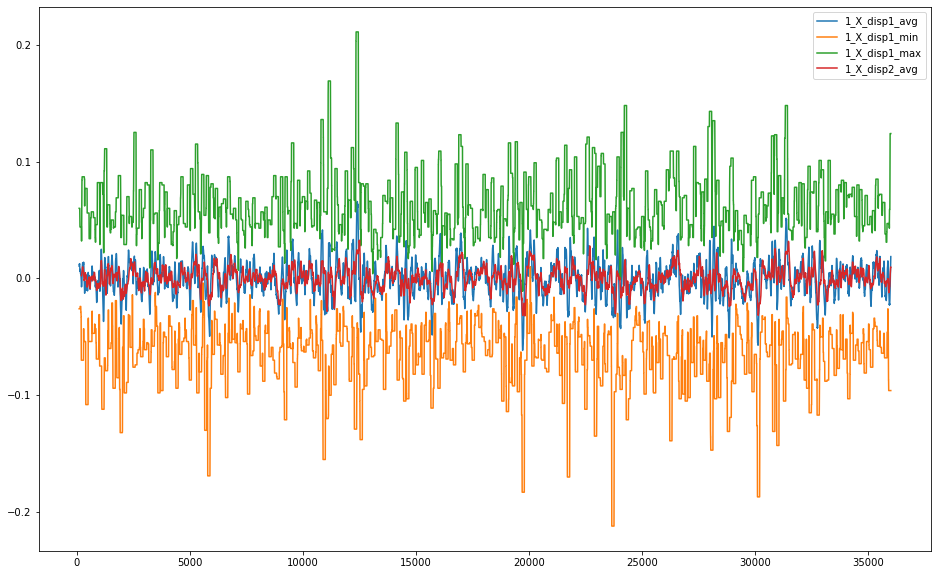

In [18]:
X_levels.plot(figsize=(16, 10))
plt.show()

In [19]:
model_data = nf.merge(motion_levels, left_index=True, right_index=True)
model_data.dropna(inplace=True)
model_data.shape

(17102, 168)

In [20]:
model_data.to_pickle('DFs/Model_data_Par1.pkl')

In [21]:
# segments[0]= data.iloc[0:18000]
#     segments[1]= data.iloc[18000:20000]
#     segments[2]= data.iloc[20000:21500]
#     segments[3]= data.iloc[21500:25500]
#     segments[4]= data.iloc[25500:27500]
#     segments[5]= data.iloc[27500:31000]
#     segments[6]= data.iloc[31000:33000]
#     segments[7]= data.iloc[33000:36000]